# 🪔 Optimal Strategy Analysis for Congklak (Mancala)
This notebook:
- Implements full Congklak rules (7 holes per side + 1 store each)
- Implements strategies: random, greedy, one-ply lookahead
- Runs tournaments and opening experiments
- Produces summary tables, plots, and Markov-chain / heatmap analyses

Instructions:
- Run cells top-to-bottom.
- Change parameters (number of simulated games, strategies) in the "Experiments" cell.

In [121]:
import random
import pandas as pd
import matplotlib.pyplot as plt

## Board Setup:
Board indexing : 
- Player A (south): holes 0..n-1, store at n_holes
- Player B (north): holes 8..2n, store at n_holes+1

In [122]:
n_holes = 6
n_seeds = 4

In [123]:
# === INITIAL SETUP ===
def init_board():
    """Inisialisasi papan berdasarkan variabel global."""
    global n_holes, n_seeds
    board = [n_seeds] * n_holes + [0] + [n_seeds] * n_holes + [0]
    return board

# === DISPLAY BOARD ===
def display_board(board):
    """Menampilkan papan Mancala secara dinamis."""
    global n_holes
    top_row = board[n_holes+1:-1][::-1]
    bottom_row = board[:n_holes]
    store_A = board[n_holes]
    store_B = board[-1]
    print("   ", "  ".join(f"[{v:2d}]" for v in top_row))
    print(f"[{store_B:2d}]" + " " * (6*n_holes - 2) + f"[{store_A:2d}]")
    print("   ", "  ".join(f"[{v:2d}]" for v in bottom_row))
    
initial_board = init_board()
board = initial_board
display_board(board)

    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]
[ 0]                                  [ 0]
    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]


# Game Setup

In [124]:
# === GAME STATUS ===
def game_over(board):
    """Cek apakah permainan selesai (salah satu sisi kosong)."""
    global n_holes
    return sum(board[:n_holes]) == 0 or sum(board[n_holes+1:-1]) == 0

# === SIMULATE MOVE ===
def simulate_move(board, move, player):
    """Simulasikan satu langkah permainan Mancala."""
    global n_holes
    board = board.copy()
    total_len = len(board)

    if player == 'A':
        if board[move] == 0:
            return board, False
        seeds = board[move]
        board[move] = 0
        pos = move
        while seeds > 0:
            pos = (pos + 1) % total_len
            if pos == total_len - 1:  # skip rumah lawan (B)
                continue
            board[pos] += 1
            seeds -= 1
        extra_turn = (pos == n_holes)
        if 0 <= pos < n_holes and board[pos] == 1:
            opp = (total_len - 2) - pos
            board[n_holes] += board[opp] + 1
            board[pos] = board[opp] = 0

    else:  # Player B
        move_idx = n_holes + 1 + move
        if board[move_idx] == 0:
            return board, False
        seeds = board[move_idx]
        board[move_idx] = 0
        pos = move_idx
        while seeds > 0:
            pos = (pos + 1) % total_len
            if pos == n_holes:  # skip rumah lawan (A)
                continue
            board[pos] += 1
            seeds -= 1
        extra_turn = (pos == total_len - 1)
        if n_holes+1 <= pos < total_len-1 and board[pos] == 1:
            opp = (total_len - 2) - pos
            board[-1] += board[opp] + 1
            board[pos] = board[opp] = 0

    return board, extra_turn

In [125]:
# === PLAY FULL GAME ===
def play_game(strategy_A, strategy_B):
    global n_holes
    board = init_board()
    game_trace = []
    first_A, first_B = [], []
    turn = 'A'
    turn_count = 0

    # --- MAIN GAME LOOP ---
    while not game_over(board):
        turn_count += 1
        if turn == 'A':
            move = strategy_A(board, 'A')
            first_A.append(move)
            board, extra = simulate_move(board, move, 'A')
            game_trace.append({
                "turn": turn_count, "player": "A", "move": move,
                "store_A": board[n_holes], "store_B": board[-1],
                "board": board.copy()
            })
            turn = 'A' if extra else 'B'
        else:
            move = strategy_B(board, 'B')
            first_B.append(move)
            board, extra = simulate_move(board, move, 'B')
            game_trace.append({
                "turn": turn_count, "player": "B", "move": move,
                "store_A": board[n_holes], "store_B": board[-1],
                "board": board.copy()
            })
            turn = 'B' if extra else 'A'

    # --- FINALISASI SETELAH GAME OVER ---
    board[n_holes] += sum(board[:n_holes])        # store A
    board[-1] += sum(board[n_holes+1:-1])         # store B

    for i in range(n_holes):
        board[i] = 0
        board[n_holes+1+i] = 0

    return board, pd.DataFrame(game_trace), first_A, first_B


In [126]:
# === PLOT SCORE PROGRESS ===
def plot_score_progress(trace):
    plt.plot(trace["turn"], trace["store_A"], label="Player A Store")
    plt.plot(trace["turn"], trace["store_B"], label="Player B Store")
    plt.xlabel("Turn")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Score Progress per Turn")
    plt.show()

In [127]:
# =========================================================
# --- RANDOM STRATEGY ---
# =========================================================
def random_strategy(board, player):
    global n_holes
    if player == 'A':
        valid = [i for i in range(n_holes) if board[i] > 0]
    else:
        valid = [i for i in range(n_holes) if board[n_holes+1+i] > 0]
    return random.choice(valid) if valid else 0

# =========================================================
# --- GREEDY STRATEGY ---
# =========================================================
def greedy_strategy(board, player):
    """Pilih langkah yang langsung menghasilkan skor tertinggi."""
    global n_holes
    best_move, best_score = 0, -float('inf')
    store_A, store_B = n_holes, len(board)-1
    for i in range(n_holes):
        if player == 'A' and board[i] == 0: continue
        if player == 'B' and board[n_holes+1+i] == 0: continue
        new_board, _ = simulate_move(board, i, player)
        score = new_board[store_A] - new_board[store_B] if player == 'A' else new_board[store_B] - new_board[store_A]
        if score > best_score:
            best_score, best_move = score, i
    return best_move

# =========================================================
# --- LOOKAHEAD STRATEGY ---
# =========================================================
def lookahead_strategy(board, player):
    """Evaluasi skor setelah 1 langkah lawan."""
    global n_holes
    opponent = 'B' if player == 'A' else 'A'
    store_A, store_B = n_holes, len(board)-1

    best_move, best_eval = 0, -float('inf')
    for i in range(n_holes):
        if player == 'A' and board[i] == 0: continue
        if player == 'B' and board[n_holes+1+i] == 0: continue

        new_board, _ = simulate_move(board, i, player)
        # lawan main greedy
        opp_move = greedy_strategy(new_board, opponent)
        new_board2, _ = simulate_move(new_board, opp_move, opponent)

        eval_score = new_board2[store_A] - new_board2[store_B] if player == 'A' else new_board2[store_B] - new_board2[store_A]
        if eval_score > best_eval:
            best_eval, best_move = eval_score, i
    return best_move

In [128]:
# =========================================================
# --- LIVE GAME INTERACTIVE ---
# =========================================================
def live_game():
    global n_holes
    board = init_board()

    print("Selamat datang di Congklak Live Mode!")
    player_choice = input("Pilih peran (A/B): ").strip().upper()
    turn = 'A'
    turn_count = 0

    while not game_over(board):
        turn_count += 1
        print(f"\n=== TURN {turn_count}: Player {turn} ===")
        display_board(board)

        if turn == player_choice:
            # rekomendasi langkah
            rec_greedy = greedy_strategy(board, turn)
            rec_look = lookahead_strategy(board, turn)
            print(f"Rekomendasi (Greedy): {rec_greedy}, (Lookahead): {rec_look}")

            move = int(input(f"Masukkan langkah Anda (0–{n_holes-1}): "))
        else:
            move = lookahead_strategy(board, turn)
            print(f"Lawan memilih langkah {move}.")

        board, extra = simulate_move(board, move, turn)
        display_board(board)
        if not extra:
            turn = 'B' if turn == 'A' else 'A'
        

    print("\n=== Permainan Berakhir ===")
    display_board(board)
    trace = pd.DataFrame({
        "turn": range(1, turn_count+1),
        "store_A": [board[n_holes]]*turn_count,
        "store_B": [board[-1]]*turn_count
    })
    plot_score_progress(trace)
    print(f"Final Skor: A = {board[n_holes]}, B = {board[-1]}")

    [ 0]  [ 0]  [ 0]  [ 0]  [ 0]  [ 0]
[29]                                  [19]
    [ 0]  [ 0]  [ 0]  [ 0]  [ 0]  [ 0]


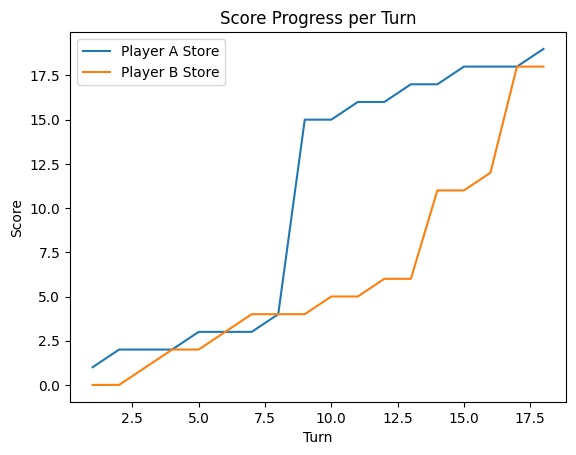

In [138]:
# === EXAMPLE RUN ===
board, trace, first_A, first_B = play_game(greedy_strategy, lookahead_strategy)
display_board(board)
plot_score_progress(trace)

In [ ]:
live_game()

Selamat datang di Congklak Live Mode!

=== TURN 1: Player A ===
    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]
[ 0]                                  [ 0]
    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]
Rekomendasi (Greedy): 2, (Lookahead): 2
    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]
[ 0]                                  [ 1]
    [ 4]  [ 4]  [ 0]  [ 5]  [ 5]  [ 5]

=== TURN 2: Player A ===
    [ 4]  [ 4]  [ 4]  [ 4]  [ 4]  [ 4]
[ 0]                                  [ 1]
    [ 4]  [ 4]  [ 0]  [ 5]  [ 5]  [ 5]
Rekomendasi (Greedy): 3, (Lookahead): 3
    [ 4]  [ 4]  [ 4]  [ 4]  [ 5]  [ 5]
[ 0]                                  [ 2]
    [ 4]  [ 4]  [ 0]  [ 0]  [ 6]  [ 6]

=== TURN 3: Player B ===
    [ 4]  [ 4]  [ 4]  [ 4]  [ 5]  [ 5]
[ 0]                                  [ 2]
    [ 4]  [ 4]  [ 0]  [ 0]  [ 6]  [ 6]
Lawan memilih langkah 1.
    [ 5]  [ 5]  [ 5]  [ 5]  [ 0]  [ 5]
[ 1]                                  [ 2]
    [ 4]  [ 4]  [ 0]  [ 0]  [ 6]  [ 6]

=== TURN 4: Player B ===
    [ 5]  [ 5]  [ 5]  [ 5] 